In [1]:
# import numpy and exp mat
import os
import numpy as np
import matplotlib.pyplot as plt

from module.QuantumSystem import SHOscillator
from module.Walker import FokkerPlankWalker
from module.Utils import VMC

np.random.seed(0)

# Spherical Harmonic Oscillator without interaction, with FokkerPlankWalker and analytical hamiltonian
In this notebook we study the Spherical Harmonic Oscillator without interaction, using the FokkerPlankWalker algorithm and analytical hamiltonian.

In a first part we present an example of our code.
In a second part we perform a grid search to find the optimal variational parameter $\alpha$.
In a third part we show that since the Ansatz correspond to the exact ground state of the hamiltonian, the mean energy with the right variational parameter ($\alpha =0.5$) is the exact groundstate energy of the system.


## Example of the code
In this section we show how the code work, choosing N, D and a variational parameter, we demonstrate how our implementation of the FokkerPlankWalker algorithm works.

In particular, we show how the calibrate part of the code works, note we do not need to specify the hyperparameter of the FokkerPlankWalker algorithm, as the $\delta$ step and the number of particles moved per step, since this are optimized to achieve the desired acceptance rate.

In [2]:
# test the classes
N = 10
D = 3

params = np.array([0.6])

system = SHOscillator(N, D)
walker = FokkerPlankWalker(system, delta=0.0001, subgroup_size=10)
vmc = VMC(system, walker, params, 
          warmup_steps=50000, run_steps=1000000,
          calibrate_steps=50000, batch_steps=500, acceptance_rate=0.57,
          verbose=True, plot=True)

In [3]:
vmc.calibrate()

-----------------
VMC calibrate
-----------------
delta: 0.016940658945086007
subgroup_size: 3
Acceptance rate: 0.636


-----------------
VMC warmup
-----------------
Parameters: [0.6]
Acceptance rate: 0.55272


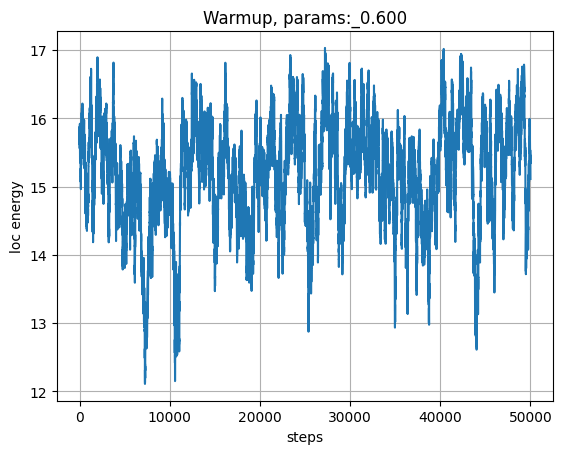

In [4]:
vmc.warmup()

-----------------
VMC run
-----------------
Parameters: [0.6]
Acceptance rate: 0.557932
Time:  2.140902042388916
Energy: 15.243783050350093 +/- 0.015533902925499424


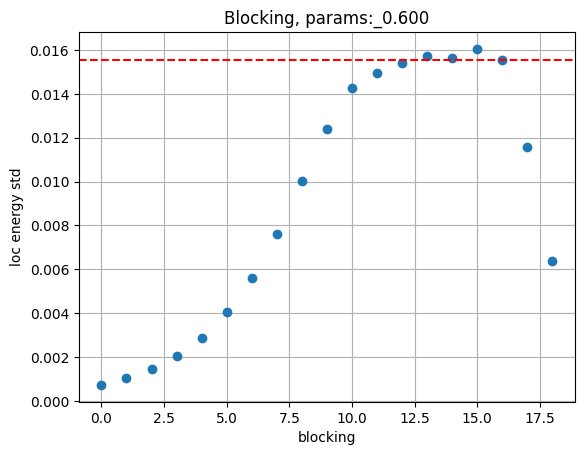

In [5]:
vmc.run()

Comment: the std of the energy as a function of the bloking transformation is a useful tool to understand if the number of steps is enough to have a good estimation of the energy. In particular, if the std is constant, it means that the number of steps is enough to have a good estimation of the energy and his uncertainty.

## Grid search
In this section we perform a grid search of $\alpha$ for fixed N and D.
In particular we save the mean energy, the std of the mean energy and the time of execution for each $\alpha$ then we plot the results.

During a grid search warmup plot of the energies and the blocking plot are saved in a directory, so one can always check if the results are rasonable.

In [6]:
params = np.array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
energies = np.zeros(len(params))
energies_std = np.zeros(len(params))
times = np.zeros(len(params))

plot_dir = 'results/GridSearch/'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

system = SHOscillator(N, D)
walker = FokkerPlankWalker(system)
vmc = VMC(system, walker, params, 
          warmup_steps=50000, run_steps=1000000,
          calibrate_steps=50000, batch_steps=500, acceptance_rate=0.57,
          verbose=True, plot=False, plot_dir=plot_dir)

for i, param in enumerate(params):
    vmc.set_params(np.array([param]))
    vmc.calibrate()
    vmc.warmup()
    vmc.run()
    energies[i] = vmc.get_energy()
    energies_std[i] = vmc.get_energy_std()
    times[i] = vmc.get_run_time()

np.save(plot_dir+'energies.npy', energies)
np.save(plot_dir+'energies_std.npy', energies_std)
np.save(plot_dir+'times.npy', times)

-----------------
VMC calibrate
-----------------
delta: 0.11641532182693484
subgroup_size: 1
Acceptance rate: 0.548
-----------------
VMC warmup
-----------------
Parameters: [0.2]
Acceptance rate: 0.63348
-----------------
VMC run
-----------------
Parameters: [0.2]
Acceptance rate: 0.629179
Time:  2.1574041843414307
Energy: 21.801467359170886 +/- 0.1001883840567785
-----------------
VMC calibrate
-----------------
delta: 0.09313225746154788
subgroup_size: 1
Acceptance rate: 0.548
-----------------
VMC warmup
-----------------
Parameters: [0.3]
Acceptance rate: 0.595
-----------------
VMC run
-----------------
Parameters: [0.3]
Acceptance rate: 0.598213
Time:  2.197598457336426
Energy: 17.015894316427513 +/- 0.04938518978525348
-----------------
VMC calibrate
-----------------
delta: 0.07450580596923831
subgroup_size: 1
Acceptance rate: 0.516
-----------------
VMC warmup
-----------------
Parameters: [0.4]
Acceptance rate: 0.58772
-----------------
VMC run
-----------------
Parameter

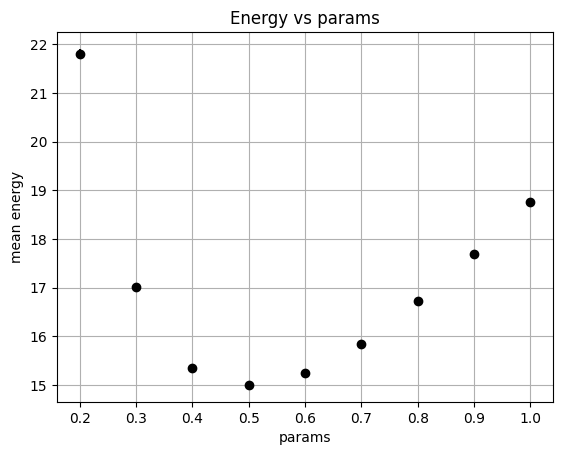

In [7]:
# plot the results
plt.figure()
plt.errorbar(params, energies, yerr=energies_std, fmt='o', color='k')
plt.xlabel('params')
plt.ylabel('mean energy')
plt.title('Energy vs params')
plt.grid()
plt.savefig(plot_dir+'Energy_vs_params.png')

## Compare with analytical results
In this section we compare the results of the grid search with the analytical results, in particular we show that the mean energy is the exact ground state energy of the system.

In [8]:
print('params:', params[np.argmin(energies)])
print('MC mean energy:', np.min(energies), '+-', energies_std[np.argmin(energies)])
print('Analytical energy:', 0.5*N*D, '+-', 0.0)

params: 0.5
MC mean energy: 15.0 +- 0.0
Analytical energy: 15.0 +- 0.0
